## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

True


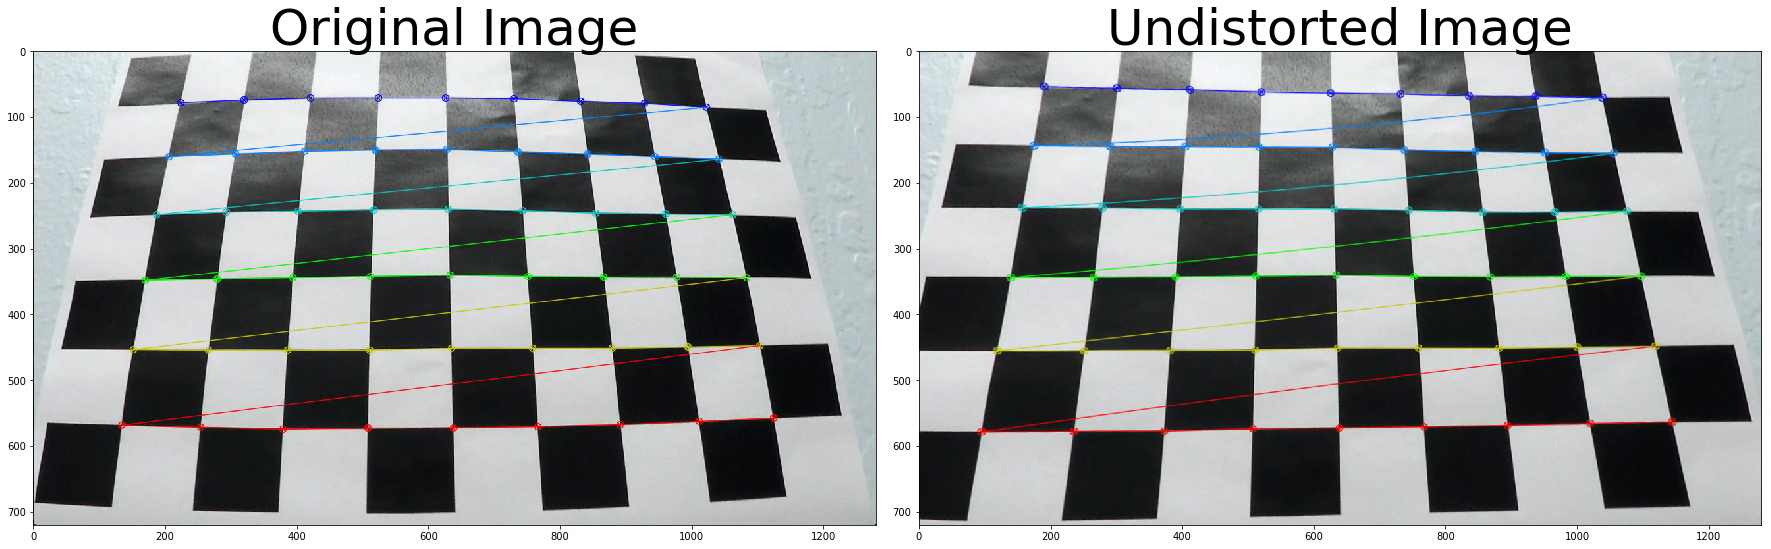

In [51]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from os import listdir
from os.path import isfile, join
%matplotlib inline

from moviepy.editor import VideoFileClip
from IPython.display import HTML

nx = 9
ny = 6
objpoints = []
imgpoints = []
objp = np.zeros((9*6,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

#Finding in mtx, dst
img = cv2.imread('camera_cal/calibration3.jpg')

# Convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Find the chessboard corners
ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

# If found, draw corners
if ret == True:
    imgpoints.append(corners)
    objpoints.append(objp)
    print(ret)
    # Draw and display the corners
    cv2.drawChessboardCorners(img, (nx, ny), corners, ret)

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

# Undistorted image ## Provide an example of a distortion corrected calibration image. (Chessboard)
undistorted = cv2.undistort(img, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Apply a distortion correction to raw images

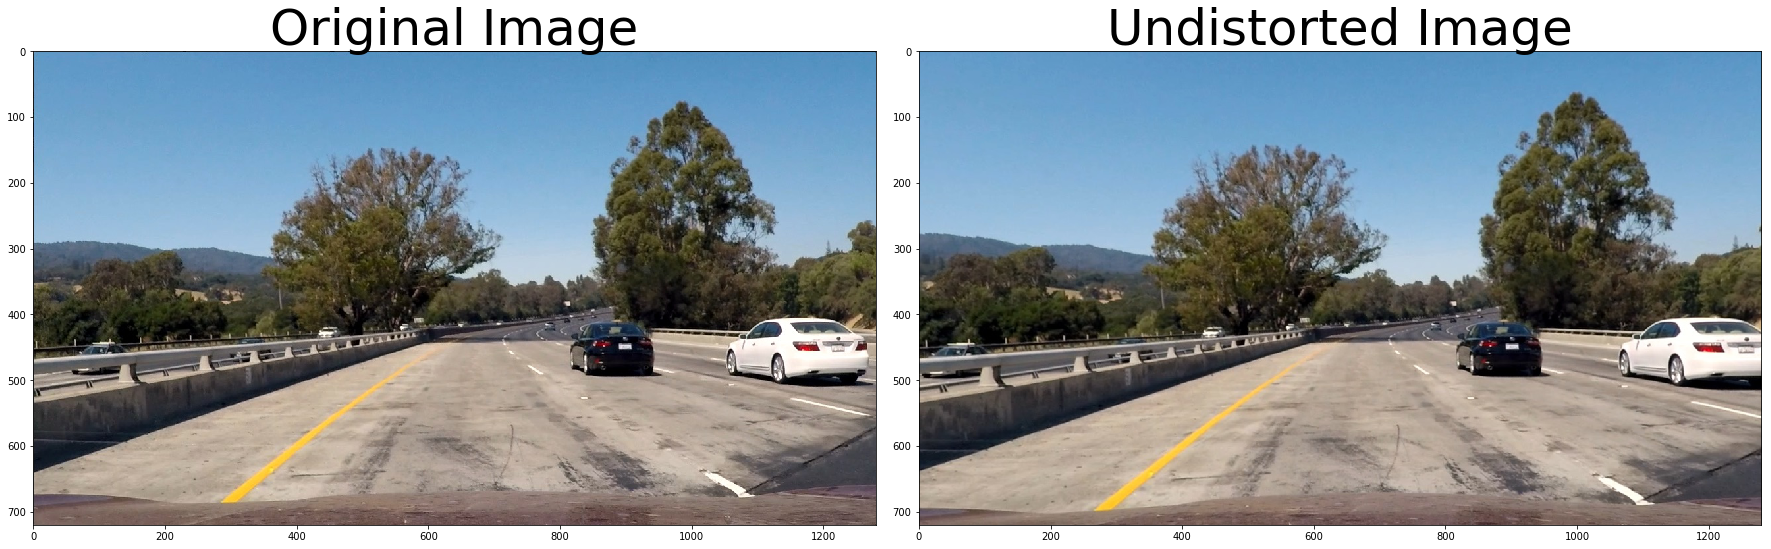

In [29]:
# Example of undistortion on test images
img = cv2.imread('test_images/test1.jpg') #TODO: try and save
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #imread reads in BGR

undistorted = cv2.undistort(img, mtx, dist, None, mtx)

undistorted_save = cv2.cvtColor(undistorted, cv2.COLOR_RGB2BGR) #imwrite saves in BGR
cv2.imwrite('undistorted_images/test1.jpg',undistorted_save)

#Plot the difference
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#img --> RGB
#undistorted -->RGB

### Use color transforms, gradients, etc., to create a thresholded binary image

In [16]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    elif orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    else:
        print('error')
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude
    grad_binary = np.zeros_like(scaled_sobel)
    # is > thresh_min and < thresh_max
    # 6) Return this mask as your binary_output image
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # Apply threshold
    return grad_binary

def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx ** 2 + sobely ** 2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag) / 255
    gradmag = (gradmag / scale_factor).astype(np.uint8)
    # Create a binary image of ones where threshold is met, zeros otherwise
    mag_binary = np.zeros_like(gradmag)
    mag_binary[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    # Apply threshold
    return mag_binary

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient
    direction = np.arctan2(abs_sobely, abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    dir_binary = np.zeros_like(direction)
    dir_binary[(direction >= thresh[0]) & (direction <= thresh[1])] = 1
    # Apply threshold
    return dir_binary

def combined_sobel_gradient_threshold(img,s_thresh_min=150,s_thresh_max=255):
    # Choose a Sobel kernel size
    ksize = 3 # Choose a larger odd number to smooth gradient measurements
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # Apply each of the thresholding functions (gradient, magnitude and direction)
    gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    grady = abs_sobel_thresh(img, orient='y', sobel_kernel=ksize, thresh=(20, 100))
    mag_binary = mag_thresh(img, sobel_kernel=ksize, mag_thresh=(30, 100))
    dir_binary = dir_threshold(img, sobel_kernel=ksize, thresh=(0.7, 1.3))
    
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    # HLS Threshold
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    
    # Threshold color channel

    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(combined)
    combined_binary[(s_binary == 1) | (combined == 1)] = 1

    '''
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 6))
    f.tight_layout()
    ax1.imshow(img) # img is RGB
    ax1.set_title('Original Image', fontsize=20)
    ax2.imshow(combined, cmap='gray')
    ax2.set_title('Sobel Magnitude and Direction Threshold', fontsize=20)
    ax3.imshow(combined_binary, cmap='gray')
    ax3.set_title('hlS Threshold', fontsize=20)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    '''
    return combined_binary, img

In [17]:
# Test on example image

fname = 'undistorted_images/test1.jpg'
img = cv2.imread(fname) #Read as BGR it is immediately covnerted into RGB at the beginning of combined_sobel_gradient_threshold function
combined_binary, img = combined_sobel_gradient_threshold(img, s_thresh_min=150,s_thresh_max=255) #binary and RGB

### Apply a perspective transform to rectify binary image ("birds-eye view")

In [31]:
# Define Source and Destination Points
def transform_image(combined_binary): #takes RGB img and binary combined_binary
    leftupperpoint  = [568,470]
    rightupperpoint = [717,470]
    leftlowerpoint  = [260,680]
    rightlowerpoint = [1043,680]
    img_size = (img.shape[1], img.shape[0])
    src = np.float32([leftupperpoint, leftlowerpoint, rightupperpoint, rightlowerpoint])
    dst = np.float32([[200,0], [200,680], [1000,0], [1000,680]])

    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)

    warped_binary = cv2.warpPerspective(combined_binary, M, img_size, flags=cv2.INTER_LINEAR) #binary
    warped_color = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR) #RGB

    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)# From now on undistorted image is set to RGB
    #warped_color = cv2.cvtColor(warped_color, cv2.COLOR_BGR2RGB)#RGB
    return warped_binary, warped_color, M, Minv



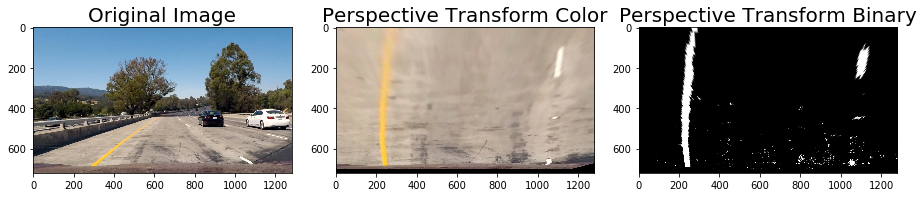

In [32]:
warped_binary, warped_color, M, Minv = transform_image(combined_binary) #in binary
#Plot the difference
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 6))
f.tight_layout()
ax1.imshow(img) # img is RGB
ax1.set_title('Original Image', fontsize=20)

ax2.imshow(warped_color, cmap='gray')
ax2.set_title('Perspective Transform Color', fontsize=20)

ax3.imshow(warped_binary, cmap='gray')
ax3.set_title('Perspective Transform Binary', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#img --> RGB
#warped_color -->RGB
#warped_binary -->binary

### Detect lane pixels and fit to find the lane boundary.

In [33]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    #print(leftx,lefty)
    #print(rightx,righty)
    

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')
    #print(left_fitx)
    #print(right_fitx)

    return out_img, left_fitx, right_fitx, ploty, left_fit, right_fit, ploty




[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


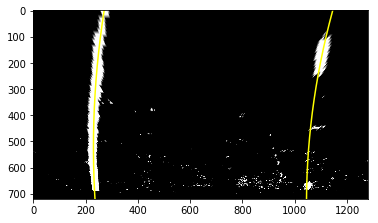

In [36]:
out_img, left_fitx, right_fitx, ploty, left_fit, right_fit, ploty = fit_polynomial(warped_binary)

# Plo the fitted polynom and warped binary image
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.imshow(warped_binary, cmap='gray')


# Radius of Curvature

In [37]:
def radius_curvature(binary_warped, left_fit, right_fit, left_fitx, right_fitx):
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    y_eval = np.max(ploty)
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curvature =  ((1 + (2*left_fit_cr[0] *y_eval*ym_per_pix + left_fit_cr[1])**2) **1.5) / np.absolute(2*left_fit_cr[0])
    right_curvature = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # Calculate vehicle center
    #left_lane and right lane bottom in pixels
    left_lane_bottom = (left_fit[0]*y_eval)**2 + left_fit[0]*y_eval + left_fit[2]
    right_lane_bottom = (right_fit[0]*y_eval)**2 + right_fit[0]*y_eval + right_fit[2]
    
    # Lane center as mid of left and right lane bottom                        
    lane_center = (left_lane_bottom + right_lane_bottom)/2.
    center_image = 640
    center = (lane_center - center_image)*xm_per_pix #Convert to meters
    position = "left" if center < 0 else "right"
    center = "Vehicle is {:.2f}m {}".format(center, position)
    
    # Now our radius of curvature is in meters
    return left_curvature, right_curvature, center 

In [38]:
left_curvature, right_curvature, center = radius_curvature(warped_binary, left_fit, right_fit, left_fitx, right_fitx)
print(left_curvature, right_curvature, center)

1095.10461584 891.236232627 Vehicle is 0.36m right


### Warp the detected lane boundaries back onto the original image

In [47]:
def draw_on_image(undist, warped_img, left_fit, right_fit, left_fitx, right_fitx, ploty, M, left_curvature, right_curvature, center, show_values = False):
    #ploty = np.linspace(0, warped_img.shape[0]-1, warped_img.shape[0] )
    #left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    #right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped_img).astype(np.uint8)
    #color_warp = np.dstack((warp_zero, warp_zero, warp_zero)) #we should make it one channel
    #print(color_warp.shape)
    color_warp = np.zeros_like(warped_img).astype(np.uint8)
    #print(color_warp)

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    Minv = np.linalg.inv(M)
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    cv2.putText(result, 'Left curvature: {:.0f} m'.format(left_curvature), (50, 50), cv2.FONT_HERSHEY_DUPLEX, 1, (255, 255, 255), 2)
    cv2.putText(result, 'Right curvature: {:.0f} m'.format(right_curvature), (50, 100), cv2.FONT_HERSHEY_DUPLEX, 1, (255, 255, 255), 2)
    cv2.putText(result, '{}'.format(center), (50, 150), cv2.FONT_HERSHEY_DUPLEX, 1, (255, 255, 255), 2)
    if show_values == True:
        fig, ax = plt.subplots(figsize=(20, 10))
        ax.imshow(result)
        
    return result



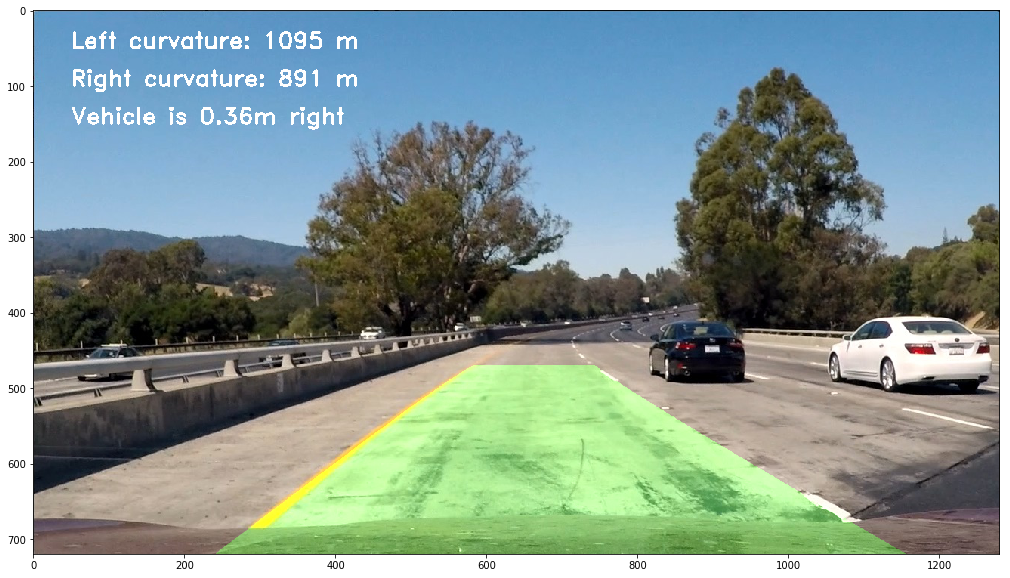

In [48]:
result = draw_on_image(img, warped_color, left_fit, right_fit, left_fitx, right_fitx, ploty, M, left_curvature, right_curvature, center, True)

### Sanity Check

In [ ]:
def sanity_check(left_fit, right_fit, left_fitx, right_fitx):
    #Check if left and right fit returned a value
    if len(left_fit) == 0 or len(right_fit) == 0:
        sanity = False
    
    ploty = np.linspace(0, 20, num=10 )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    distance = np.mean(right_fitx - left_fitx)
    distance = np.mean(left_fitx-right_fitx)
    print(distance)
    if distance >=160 and distance <=450:
        sanity = True
    else:
        sanity = False
        
    # TODO: Might require more sanity checks
    
    return sanity

print(sanity_check(left_fit, right_fit, left_fitx, right_fitx))
        
        
        
        

In [58]:
class ProcessLine():
    def __init__(self, img):
        self.last_left = None
        self.last_right = None
        self.left_fit = None
        self.right_fit = None
        self.counter = 0
        self.reset_counter = 0
        

        
    #lane =Lane()
    def __call__(self, img):
        #Undistort the imae wih camera calibration matrix M
        undistorted = cv2.undistort(img, mtx, dist, None, mtx)

        #Apply thresholding to get binary image, takes BGR undistorted image and results binary and RGB image
        combined_binary, img = combined_sobel_gradient_threshold(undistorted, s_thresh_min=150,s_thresh_max=255)

        #Apply perspecive transform
        warped_binary, warped_color, M, Minv = transform_image(combined_binary)

        #Detect line pixels and apply polynomial fit
        out_img, left_fitx, right_fitx, ploty, left_fit, right_fit, ploty = fit_polynomial(warped_binary)

        #Calculate curvature radius
        left_curvature, right_curvature, center = radius_curvature(warped_binary, left_fit, right_fit, left_fitx, right_fitx)

        #Apply computer vision steps into original image
        result = draw_on_image(img, warped_color, left_fit, right_fit, left_fitx, right_fitx, ploty, M, left_curvature,
                      right_curvature, center, False)
        result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
        '''
        img = cv2.imread('test_images/test1.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        pipeline(img)
        plt.imshow(result)
        '''
        return result

### Video Processing

In [63]:
input_video = './project_video.mp4'
output_video = './project_video_solution.mp4'

## You may uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip(input_video).subclip(0,5)
clip1 = VideoFileClip(input_video)

# Process video frames with our 'process_image' function
process_image = ProcessLine('./camera_cal/calibration*.jpg')

white_clip = clip1.fl_image(process_image)

%time white_clip.write_videofile(output_video, audio=False)

[MoviePy] >>>> Building video ./project_video_solution.mp4
[MoviePy] Writing video ./project_video_solution.mp4



 12%|█▏        | 152/1261 [00:41<05:26,  3.40it/s]


 24%|██▍       | 303/1261 [01:25<04:45,  3.36it/s]


 36%|███▌      | 454/1261 [02:09<03:49,  3.52it/s]


 48%|████▊     | 605/1261 [02:54<03:18,  3.30it/s]


 60%|█████▉    | 756/1261 [03:38<02:23,  3.53it/s]


 72%|███████▏  | 907/1261 [04:22<01:39,  3.54it/s]


 84%|████████▍ | 1057/1261 [05:08<01:06,  3.08it/s]


 96%|█████████▌| 1205/1261 [05:53<00:16,  3.42it/s]


100%|█████████▉| 1260/1261 [06:08<00:00,  3.47it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project_video_solution.mp4 

CPU times: user 4min 1s, sys: 3.26 s, total: 4min 4s
Wall time: 6min 11s


In [64]:
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format(output_video))